In [ ]:
# IMPORTING MODULES
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
# import plotly.express as px
# import chart_studio.plotly as py
# import plotly.figure_factory as ff
# import plotly.graph_objects as go


## Setting up path variables for easy and [generalized ?] access throughout the notebook

In [ ]:
# SETTING PATH VARIABLES
JUDICIAL_DATA_CSV_FOLDER_PATH = "/kaggle/input/precog-recruitment-task-csv/"

ACTS_SECTIONS_CSV = os.path.join(
                        JUDICIAL_DATA_CSV_FOLDER_PATH, 
                        "acts_sections.csv"
                    )

CASES_CSV_FOLDER = os.path.join(
                        JUDICIAL_DATA_CSV_FOLDER_PATH, 
                        "cases/cases/"
                    )

JUDGES_CSV = os.path.join(
                        JUDICIAL_DATA_CSV_FOLDER_PATH,
                        "judges_clean/judges_clean.csv"
                    )
KEYS_CSV = os.path.join(
                        JUDICIAL_DATA_CSV_FOLDER_PATH, 
                        "keys.csv"
                    )



# To test if the file is being read properly #

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

### Analyzing cases csv data 

- We will read the csv file first
- We will later change this to a for-loop so we can loop through every csv file




In [ ]:
# ()
#     df = pd.read_csv(os.path.join(CASES_CSV_FOLDER, "cases_2014.csv"))
#     df.head()
# joined_files = os.path.join(CASES_CSV_FOLDER, "cases_*.csv")
# joined_list = glob.glob(joined_files)
# df = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)


In [ ]:
## Messing around

# df = df.sort_values(by = ['date_of_filing'], ascending = False)
# df.head()

### Plotting the number of pending cases 

#### How the data was preprocessed and analyzed?
- This was achieved by using the `date-of-filing` and `date-of-decision` columns
- A case is considered pending on a given date if the `date-of-filing` has passed but the `date-of-decision` has not been passed.
- The columns `date-of-filing` and `date-of-decision` were cleaned using the `Pandas.to_datetime()` method with the parameter `errors = coerce` to fill `NaT` in entries which were not in the correct `TimeStamp` format.
- The previous steps ensures that there are no faulty entries in either columns.
- A frequency map was created using `DataFrame[column].value_counts()`.
- Frequency of non occurent dates were filled with zeros using the `PandaSeries.reindex(range_of_dates, fill_value=0)` method.
- The graph is only shown for the given year, since, no cases filed after the given year are actually present in the `csv` file.

In [ ]:
def pending_cases(df : pd.DataFrame, case_csv_year : int): 
    df['date_of_filing'] = pd.to_datetime(
        df['date_of_filing'], errors='coerce'
    ).dt.date

    df['date_of_decision'] = pd.to_datetime(
        df['date_of_decision'], errors='coerce'
    ).dt.date
    
    range_of_dates = pd.date_range(
                        f"{case_csv_year}-01-01", 
                        f"{case_csv_year+1}-01-01"
                    )

    freq_filed_cases = df['date_of_filing'].value_counts()\
                                           .asfreq('D', fill_value=0)

#     freq_solved_cases = df['date_of_decision'].value_counts()\
#                                               .asfreq('D', fill_value=0)

#     freq_pending_cases = freq_filed_cases.subtract(freq_solved_cases)

    df_pending_cases = pd.DataFrame({
            'Date' : freq_filed_cases.index, 
            'Num_filed_cases' : freq_filed_cases.values, 
        })
    
    df_pending_cases['weekday'] = df_pending_cases['Date'].dt.day_name()
    
    return df_pending_cases

In [ ]:
df_pending_cases = pending_cases(curr_df, 2014)
case_csv_year = 2014

pending_cases_plot_img(df_pending_cases, case_csv_year)

In [ ]:
curr_df = pd.read_csv(os.path.join(CASES_CSV_FOLDER, "cases_2014.csv"))

## Pending Cases plotter
- The number of cases received [TBX]

In [ ]:
def pending_cases_plot_img(df : pd.DataFrame, case_csv_year : int):
    fig = df.plot(
        x = 'Date', 
        y = ['Num_filed_cases'], 
        xlim = (f'{case_csv_year}-01-01', f'{case_csv_year + 1}-01-01'),
        ylim = (0,150000),
        figsize = (15,4)
    )
    return fig

## Iterating through all cases csv files
- Since, each `cases_[year].csv` is massive (~1-2 gigabytes) we will use a diff subplot for each csv file
- Each plot image is stored in a `plot_img_list`

In [ ]:
plot_img_list = []
df_list = []
for year in range(2010, 2019):
    curr_df = pd.read_csv(os.path.join(CASES_CSV_FOLDER, f"cases_{year}.csv"))
    df_pending_cases = pending_cases(curr_df, year)
    df_list.append(df_pending_cases)
    plot_img_list.append(pending_cases_plot_img(df_pending_cases, year))

## Plotting number of cases filed on each day
- The `plot_img_list` obtained earlier can be iterated over and shown as subplots

In [ ]:
curr_df = pd.read_csv(os.path.join(CASES_CSV_FOLDER, "cases_2014.csv")
df_pending_cases = pending_cases(curr_df, 2014)

# df.head()

In [ ]:
curr_df_pending = pending_cases(curr_df)
curr_df_pending['weekday'] = curr_df_pending['date'].dt.day_name()

# curr_df_pending.head()


freq_weekday = curr_df_pending.groupby(['weekday']).sum()
freq_weekday.head()

# Insights on graphs obtained:
## Physical features of the graph
- The trend seems to violently oscillate.
- The amplitude of oscillation is increasing YoY.
- Weekends seem to be minimae getting only a fraction of cases on weekdays.
- Mondays and Wednesdays seem to be the maximae with Mondays receiving the highest number of cases on average.

## Implications of the physical features
- The density of cases filed are extremely high on weekdays, which suggests the direct
- The order of number of cases filed on peak days is of the order of 30000.
- The number of cases filed on peak days has steadily increased over the years.
- The period of 

# CLASSIFICATION PROBLEM IDEAS

- Given a day and Case ID, will it be decided on a given day.
- Given a day and Case ID, will it be decided on the next case day.
- 
- 

# OFFICIAL SUBMISSION AREA STARTS**

# Hello! I'm Ujjwal Shekhar:)
I will be analyzing the database of ~80 million Indian district court data across states from the Development Data Lab.

The csv file has been downloaded from [the dropbox link](https://www.dropbox.com/sh/hkcde3z2l1h9mq1/AAB2U1dYf6pR7qij1tQ5y11Fa/csv?dl=0&subfolder_nav_tracking=1).

The metadata can be found here:
- [Acts sections metadata](https://docs.google.com/spreadsheets/d/e/2PACX-1vTNxZtceqgzYlUogz-gJfMfqm-RygJZcqfZiFCQAsJYFG7BU1_ZT5aKTPrNODeDgRnoyZFBnjt2sghd/pubhtml)
- [All cases metadata](https://docs.google.com/spreadsheets/u/1/d/e/2PACX-1vSkFghNxGjLxIAsjvUPkW8IV2AF1vf2KOQV93vMhB0TD3CBT13gah1LczI8W0d3Eom1zPcroBuPQ-uy/pubhtml)
- [Judges metadata](https://docs.google.com/spreadsheets/d/e/2PACX-1vSqcp7VlnFB4ujCCHV5uGHjBlwYf7Mo4B3N3aqdiAukS7VMY8lLGU9ejhHH4c8qCse8l1kc8yIkCnq9/pubhtml)

The following project was done as a part of the recruitment task given by [Precog Research Lab](https://precog.iiit.ac.in/).

# Importing modules and libraries

In [ ]:
# IMPORTING MODULES
import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib 
matplotlib.style.use('ggplot')
# from pandas.api.types import CategoricalDtype
# import plotly.express as px
# import chart_studio.plotly as py
# import plotly.figure_factory as ff
# import plotly.graph_objects as go


# Context
![Shashi Tharoor gif](https://2.bp.blogspot.com/-6r5_T5XrC9Q/U6BLfMvIoLI/AAAAAAAABIc/kC5zGcduYCg/s1600/Waqt-ShashiKapoor.gif)
    
Ask any indian how they feel about the judicial system of their country, and they will come up with constant anecdotes of cases being stuck for years. The confidence that people have in our country's judicial system seems low, with as many as [4.7 crore cases](https://www.thehindu.com/news/national/indian-judiciary-pendency-data-courts-statistics-explain-judges-ramana-chief-justiceundertrials/article65378182.ece) pending.

We will look at a subset of cases (from 2010 to 2018) and look at judges' data and various other data provided to us. This will be a part of the **ANALYSIS** section of the recruitment task given.

Following this, we come up with a classification problem that will help with [TBX]. This will be a part of the **CLASSIFICATION** section.

```
NOTE: The markdown provided in this `.ipynb notebook` will also be clubbed together in the README.MD file in the Github Repository associated with the notebook.
```

# Setting path variables 
We will setup global path variables for easy access and uniformity throughout the notebook.

**_NOTE_**:
- Since each `cases_{year}.csv` file is very large, we will store the path to the `cases` folder instead.
- Similar reasons for the `/keys/` folder. 

In [ ]:
JUDICIAL_DATA_CSV_FOLDER_PATH = "/kaggle/input/precog-recruitment-task-csv/"

ACTS_SECTIONS_CSV = os.path.join(
                        JUDICIAL_DATA_CSV_FOLDER_PATH, 
                        "acts_sections/acts_sections.csv"
                    )

CASES_CSV_FOLDER = os.path.join(
                        JUDICIAL_DATA_CSV_FOLDER_PATH, 
                        "cases/cases/"
                    )

JUDGES_CSV = os.path.join(
                        JUDICIAL_DATA_CSV_FOLDER_PATH,
                        "judges_clean/judges_clean.csv"
                    )
KEYS_CSV_FOLDER = os.path.join(
                        JUDICIAL_DATA_CSV_FOLDER_PATH, 
                        "key/keys/"
                    )
print( f"""
    Judges CSV file path : {JUDGES_CSV}
    Cases CSV folder path : {CASES_CSV_FOLDER}
    Acts Sections CSV file path: {ACTS_SECTIONS_CSV}
    Keys CSV file path: {KEYS_CSV_FOLDER}
""")

# Pre-processing and analyzing data 
We will try analyzing the datasets we have. But before we analyze the data itself, we must get comfortable with the database and how it is structured and ensure that the data types are appropriate.
Following this we will look at many exploratory features of the data provided, this will be done for every file and at a later point, the preprocessing part will be standardised as a function for future use.


## Judges data
The [Judges metadata](https://docs.google.com/spreadsheets/d/e/2PACX-1vSqcp7VlnFB4ujCCHV5uGHjBlwYf7Mo4B3N3aqdiAukS7VMY8lLGU9ejhHH4c8qCse8l1kc8yIkCnq9/pubhtml) file gives us the following information, 

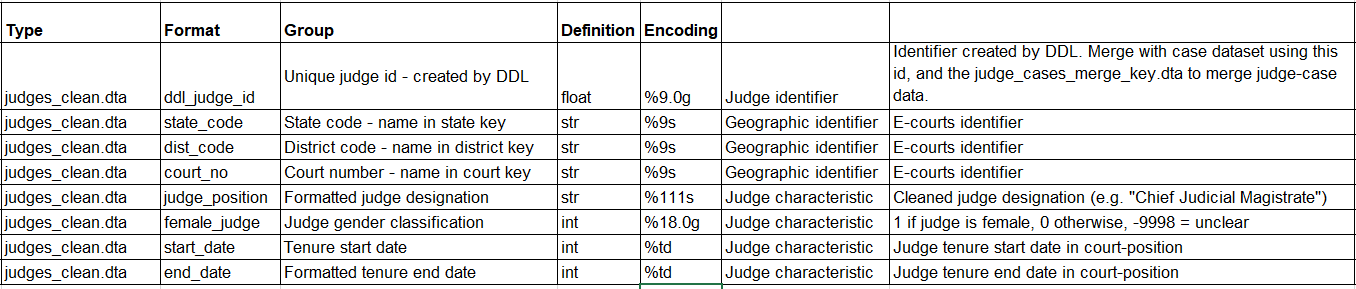

In [ ]:
df = pd.read_csv(JUDGES_CSV)
df.head()

Let's check whether or not the data type of each column is correct.

In [ ]:
df.dtypes

We can see that the `object` datatypes will actually be of the following types
- **judge_position** : `string`
- **female_judge** : [TBX]
- **start_date** and **end_date** : `Pandas.DateTime`

We will correct these dataypes first

In [ ]:
object_columns = df.select_dtypes(include = "object").columns
df[object_columns] = df[object_columns].astype("string")
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce').dt.date
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce').dt.date

df.dtypes

## Changing columns labels and replacing less readable values
On referring the DDL provided metadata (shown above), we realize that the following encoding was used in the `female_judge` column.

- 0 : male
- 1 : female
- -9998 : unclear

In [ ]:
df['female_judge'] = df['female_judge'].replace(
                                            ['0 nonfemale', '1 female', '-9998 unclear'],
                                            ['Male', 'Female', 'Unclear/Others']
                                        )
df = df.rename({'female_judge': 'gender'}, axis=1)
df['gender'] = df['gender'].astype("string")
df['gender'].head()

Since there is no numerical data to be analyzed, we will not use the `df.describe()` method here.

### Correlation matrix using Plotly.Express
We will use the correlation matrix to ensure that there are no columns with high correlation

**_NOTE:_** The corresponding correlation value has been shown as a colour, please refer to the color beside the correlation matrix image.

In [ ]:
px.imshow(df.corr(),title="Correlation Plot of Judges' database")

We can see that `ddl_judge_id` and `state_code` are highly positively correlated, with a correlation value of ~$0.97$ .Other pairs of columns are not correlated for the most part (`Absolute value of theo order of correlation ~` $0.01$)

<br>

### Overall gender demographic across judges

In [ ]:
num_genders = df['gender'].value_counts()
num_genders.head()

fig = num_genders.plot.bar(x='lab', y='val', rot=0, title="Overall gender demographic across judges")

The ratio of male judges to female is approximately $2:1 :: Male : Female$

In [ ]:
fig=px.histogram(df, 
                 x="judge_position",
                 color="gender",
                 hover_data=df.columns,
                 title="Judge demographic in different powers",
                 barmode="stack",
                 )\
      .update_xaxes(categoryorder="total descending")
fig.show()

Using the above histogram plot, we can see that majority of the judges are:

- Chief judicial magistrate
- Civil judge senior division
- Civil judge junior division
- Civil court
- Judicial magistrate court
- Additional Chief judicial magistrate
- City civil and sessions court
- Additional district and sessions court
- Family court
- Principal district and sessions court
- Principal civil judge; etc,.

We also observe that there are more male judges than female judges


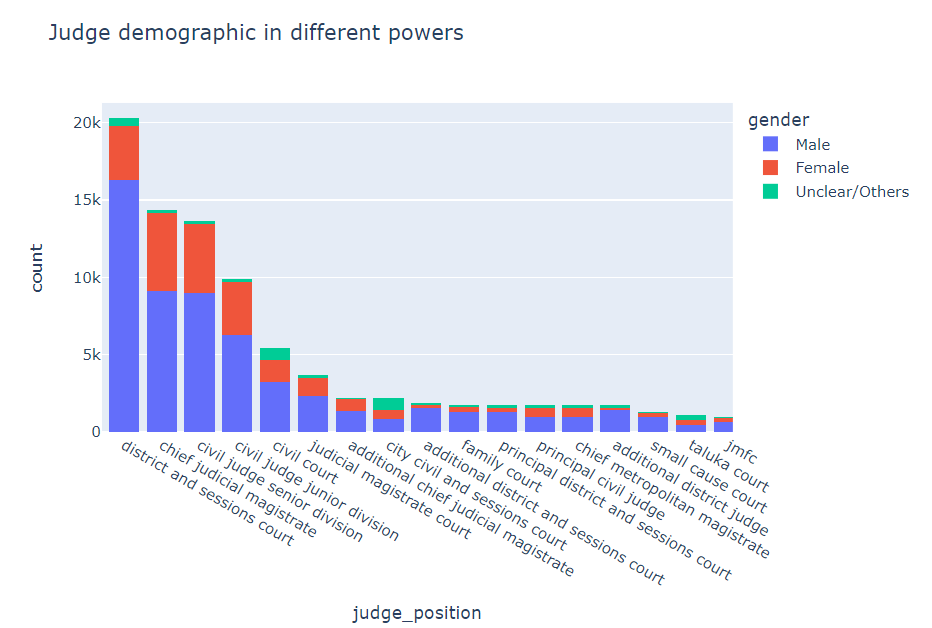

### Judges' gender demographic in different states

In [ ]:
fig=px.histogram(df, 
                 x="state_code",
                 color="gender",
                 hover_data=df.columns,
                 title="Judge gender demographic in different states",
                 barmode="stack",
                 )
fig.show()

We can see that the state with `state_code` = 0 has the highest total number of judges (~$22000$)

**_NOTE:_** The states have been anonimized using state codes.


We seem to have hit a roadblock, the judges csv seemingly gives no other insight.

### Trying to get hints for further analysis

Let's check if `end_date` has `NaN` values, so we can get the difference between them to get `total_days` they have worked for.

In [ ]:
df.isnull().any()

Turns out that the `end_date` column DOES have `Nan` values, we can replace the `NaN` values to a date that can't logically be valid (like `01-01-2222`). Then we can simply get rid of all entries in the`total_days` column that can't be physically possible. 

### Creating the total days column

In [ ]:
df['total_days'] = (df['end_date'] - df['start_date']) / np.timedelta64(1, 'D')
df

### Making a temporary dataframe
We make a temporary dataframe and select only the entries with`judge_position` entries occuring more than $2000$ times  

In [ ]:
sub_df = df.filter(['judge_position','total_days', 'gender'], axis=1)\
        [df.groupby('judge_position').judge_position.transform('count')>2000].copy() 
sub_df

### Violin plot to get insights on the data obtained

In [ ]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.violinplot(x='total_days', 
               y='judge_position', 
               data=sub_df, 
               hue='gender', 
               ax=ax,
               title = "Judge_position in total days worked for",
              )

In [ ]:
plt.figure(figsize=(15,10))
sns.pairplot(sub_df,hue="judge_position")
plt.title("Looking for Insights in Data")
plt.legend()
plt.tight_layout()
plt.plot()

# Bibliography
- https://stackoverflow.com/questions/50089903/convert-column-to-timestamp-pandas-dataframe
- https://www.geeksforgeeks.org/get-minimum-values-in-rows-or-columns-with-their-index-position-in-pandas-dataframe/
- https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe
- https://www.w3schools.com/python/pandas/ref_df_min.asp#:~:text=The%20min()%20method%20returns,minimum%20value%20for%20each%20row.
- https://www.geeksforgeeks.org/how-to-sort-a-pandas-dataframe-by-date/
- https://www.datasciencemadesimple.com/create-frequency-table-of-column-in-pandas-python-2/
- https://datagy.io/pandas-value-counts/
- https://stackoverflow.com/questions/47136436/python-pandas-convert-value-counts-output-to-dataframe
- https://stackoverflow.com/questions/32888124/pandas-out-of-bounds-nanosecond-timestamp-after-offset-rollforward-plus-adding-a
-  https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe
-  https://stackoverflow.com/questions/26097916/convert-pandas-series-to-dataframe
-  https://stackoverflow.com/questions/61233041/module-not-found-error-no-module-named-chart-studio
-  https://plotly.com/python/ipython-notebook-tutorial/
- https://stackoverflow.com/questions/68149831/find-if-date-is-weekend-or-weekday-in-pandas-dataframe
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html
- https://stackoverflow.com/questions/28503445/assigning-column-names-to-a-pandas-series
- https://www.kaggle.com/code/durgancegaur/a-guide-to-any-classification-problem
- https://pynative.com/pandas-set-index/
- https://stackoverflow.com/questions/49735683/python-removing-rows-on-count-condition
- https://stackoverflow.com/questions/62230507/multiple-columns-for-hue-parameter-in-seaborn-violinplot
- https://seaborn.pydata.org/generated/seaborn.violinplot.html
- https://stackoverflow.com/questions/34682828/extracting-specific-selected-columns-to-new-dataframe-as-a-copy

# OFFICIAL SUBMISSION AREA E**
